# Data 620
## Graph Visualization

### By Luis Munoz Grass

This week's assignment is to:
1. Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from https://snap.stanford.edu/data/), please feel free at this point to load just a small subset of the nodes and edges.
2. Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.
3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.
4. Please record a short video (~ 5 minutes), and submit a link to the video as part of your homework submission.

## Marvel Characters and appearances

**Source: http://konect.cc/networks/marvel/**

### Description of the dataset from the source:

This is the fictional collaboration network of characters in works of Marvel, a publisher of comic books based in the United States of America. The network is bipartite. Nodes are characters and works, and an edge is present when a character appears in a work. The dataset takes works only into account if thy were published starting in 1961. To cite the paper: "We only consider here comics published after Issue 1 of Fantastic Four (dated November 1961), which is understood as the point of departure of the Marvel Age of Comics." The data was extracted from the Marvel Chronology Project (MCP) created by Russ Chappell (www.chronologyproject.com).


In [4]:
# To download data files from GitHub repo
!wget https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/Week%202/character_names.txt
!wget https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/Week%202/out.marvel
!wget https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/Week%202/comic_names.txt



--2025-06-15 22:16:51--  https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/Week%202/character_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189310 (185K) [text/plain]
Saving to: ‘character_names.txt.1’

character_names.txt 100%[===================>] 184.87K  --.-KB/s    in 0.04s   

2025-06-15 22:16:51 (4.96 MB/s) - ‘character_names.txt.1’ saved [189310/189310]

--2025-06-15 22:16:51--  https://raw.githubusercontent.com/Lfirenzeg/msds620/refs/heads/main/Week%202/out.marvel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [35]:
import networkx as nx

# Create an empty graph
B = nx.Graph()

# Load edges from file (limit for performance if needed)
with open("out.marvel", "r") as f:
    for line in f:
        if line.startswith('%'):  # Ignore comments
            continue
        node1, node2 = map(int, line.strip().split())
        B.add_edge(node1, node2)

print(f"Total nodes: {B.number_of_nodes()}")
print(f"Total edges: {B.number_of_edges()}")


Total nodes: 19428
Total edges: 96662


We’ve loaded the full bipartite graph, which currently stants at around 19k nodes (characters + comics) and around 97k edges (appearances). Since this is too large for a quick exploration, we’ll simplify it by sampling a subset.

In [36]:
B = B.edge_subgraph(list(B.edges)[:5000]).copy()

print(f"Total nodes: {B.number_of_nodes()}")
print(f"Total edges: {B.number_of_edges()}")


Total nodes: 1632
Total edges: 5000


So we have sampled the first 5000 edges, giving us about 1,632 nodes. This smaller graph should be easier to work with for analysis and visualization.

In [37]:
characters = {n for n in B.nodes if n <= 6486}
comics = set(B.nodes) - characters

# Project character–character graph based on shared comics
from networkx.algorithms import bipartite

G_proj = bipartite.weighted_projected_graph(B, characters)

print(f"Projected graph has {G_proj.number_of_nodes()} nodes and {G_proj.number_of_edges()} edges")


Projected graph has 1223 nodes and 24737 edges


By projecting onto character nodes, we get 1223 characters connected via 24,737 edges, where edge weights reflect co-appearances.

### Graph Diameter

In [38]:
# Diameter (on largest connected component)
largest_cc = max(nx.connected_components(G_proj), key=len)
G_sub = G_proj.subgraph(largest_cc)

diameter = nx.diameter(G_sub)
print(f"Graph diameter: {diameter}")

Graph diameter: 5


Within the largest connected component, the diameter is 5. This meants that the two most distant characters are connected through at most five co-appearance links.

### Degree Centrality

In [39]:
centrality = nx.degree_centrality(G_sub)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree centrality:")
for node, score in top_nodes:
    print(f"Node {node} — score: {score:.4f}")

Top 5 nodes by degree centrality:
Node 5716 — score: 0.2659
Node 2557 — score: 0.2550
Node 6306 — score: 0.2525
Node 3805 — score: 0.2433
Node 5736 — score: 0.2349


These top 5 nodes have the highest degree centrality, meaning they co-appear with many others. Once we map IDs to names, these could be major characters. So if you want to take any guesses of who these nodes represent, this is the moment before scrolling down.

## Identifying our nodes

We have started exploring the network, but what good would it do if we can't identify a node when we need one? The website where I got the dataset did not include the files identifying the names, but they were found in a link referencing the original source: https://bioinfo.uib.es/~joemiro/marvel.html

The files were located and saved as .txt files so at that point they were ready to upload to the notebook. So we can start with loading the character names.

In [40]:
character_names = {}

with open("character_names.txt", "r", encoding="utf-8") as f:
    for line in f:
        if line.startswith("Vertex"):
            parts = line.strip().split(":")
            if len(parts) == 2:
                vertex_id = int(parts[0].split()[1])
                name = parts[1].strip()
                character_names[vertex_id] = name


And we can do the same thing for the comic book names:

In [41]:
comic_names = {}

with open("comic_names.txt", "r", encoding="utf-8") as f:
    for line in f:
        if line.startswith("Vertex"):
            parts = line.strip().split(":")
            if len(parts) == 2:
                vertex_id = int(parts[0].split()[1])
                title = parts[1].strip()
                comic_names[vertex_id] = title


So going back to the revel of our top 5 characters by degree centrality:

In [42]:
print("Top 5 characters by degree centrality:")
for node, score in top_nodes:
    name = character_names.get(node, f"ID {node}")
    print(f"{name} (node {node}) — score: {score:.4f}")


Top 5 characters by degree centrality:
THING/BENJAMIN J. GRIMM (node 5716) — score: 0.2659
HUMAN TORCH/JOHNNY STORM (node 2557) — score: 0.2550
WOLVERINE/LOGAN (node 6306) — score: 0.2525
MR. FANTASTIC/REED RICHARDS (node 3805) — score: 0.2433
THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE OLSON/LOREN OLSON (node 5736) — score: 0.2349


### Clustering Coefficient

In [43]:
clustering = nx.clustering(G_sub)

print("Top 5 characters by clustering coefficient:")
top_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)[:5]
for node, score in top_clustering:
    name = character_names.get(node, f"ID {node}")
    print(f"{name} (node {node}) — score: {score:.4f}")


Top 5 characters by clustering coefficient:
24-HOUR MAN/EMMANUEL (node 1) — score: 1.0000
ABBOTT, JACK (node 7) — score: 1.0000
ABOMINATION | MUTANT X-VERSE (node 11) — score: 1.0000
ABOMINATRIX (node 12) — score: 1.0000
ABSORBING MAN | MUTANT X-VERSE (node 17) — score: 1.0000


It seems that top 5 characters all have high clustering coefficient, so it might be worth exploring how many share this chacteristic?

In [44]:
high_clustering = [n for n, v in clustering.items() if v == 1.0]
print(f"Number of characters with clustering coefficient = 1: {len(high_clustering)}")


Number of characters with clustering coefficient = 1: 564


At this point we found a large number of characters with a perfect clustering coefficient of 1.0. This typically reflects minor or peripheral characters who only appear in very limited and tight-knit storylines (let's say one comic issue with the same group of characters)

In [45]:
almost_clique = [n for n, v in clustering.items() if v >= 0.9]
print(f"Number of characters with clustering ≥ 0.9: {len(almost_clique)}")


Number of characters with clustering ≥ 0.9: 673


For example, characters like:

24-HOUR MAN/EMMANUEL

ABOMINATRIX

ADORA CLONE

all exhibited a clustering coefficient of 1.0. These characters likely appeared in isolated story arcs or one-off appearances with a consistent cast.

### Betweenness Centrality

In [46]:
betweenness = nx.betweenness_centrality(G_sub)

print("Top 5 characters by betweenness centrality:")
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
for node, score in top_betweenness:
    name = character_names.get(node, f"ID {node}")
    print(f"{name} (node {node}) — score: {score:.4f}")


Top 5 characters by betweenness centrality:
HAVOK/ALEX SUMMERS (node 2397) — score: 0.0803
DR. STRANGE/STEPHEN STRANGE (node 1602) — score: 0.0609
ABSORBING MAN/CARL CRUSHER CREEL (node 16) — score: 0.0505
ABOMINATION/EMIL BLONSKY (node 10) — score: 0.0484
HUMAN TORCH/JOHNNY STORM (node 2557) — score: 0.0420


To explore character importance further, I calculated both:

*Degree centrality* which would indicate the number of direct co-appearance connections; and *betweenness centrality*, indicating frequency with which a character sits on the shortest paths between other characters.


In [ ]:
!pip install adjustText

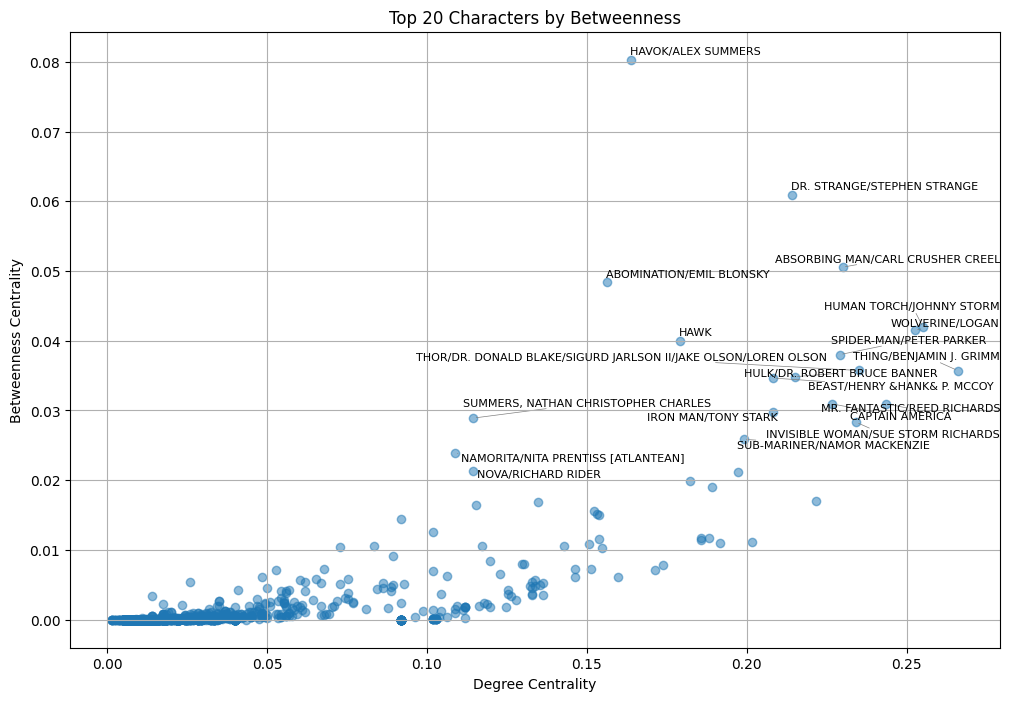

In [51]:
from adjustText import adjust_text
import matplotlib.pyplot as plt

# Create plot
plt.figure(figsize=(12, 8))
plt.scatter(degrees, btws, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Top 20 Characters by Betweenness")
plt.grid(True)

# Select top 20 by betweenness
top_n = 20
top_nodes = sorted(nodes, key=lambda n: betweenness[n], reverse=True)[:top_n]

# Collect text annotations
texts = []
for n in top_nodes:
    x = centrality[n]
    y = betweenness[n]
    label = character_names.get(n, f"ID {n}")
    texts.append(plt.text(x, y, label, fontsize=8))

# Auto-adjust to reduce overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.show()


To visualize this contrast, I created a scatterplot comparing degree and betweenness scores across characters. The plot reveals distinct clusters:

Characters in the upper right of the plot have both wide connections and important structural roles as bridges. These include:

**High Degree, High Betweenness**

HUMAN TORCH/JOHNNY STORM

THING/BENJAMIN J. GRIMM

WOLVERINE/LOGAN

SPIDER-MAN/PETER PARKER

These are major protagonists who frequently co-appear with a broad range of characters and help connect key narrative arcs across the universe.

**High Degree, Low Betweenness**

Characters with high degree but relatively low betweenness are widely connected but stay within tightly knit communities. For example:

INVISIBLE WOMAN/SUE STORM RICHARDS

SUB-MARINER/NAMOR MACKENZIE

CAPTAIN AMERICA

These characters appear often, but typically in recurrent teams (e.g., Fantastic Four, Avengers), so they don't serve as cross-narrative bridges as frequently.

**Low Degree, High Betweenness**

The top of the plot reveals characters with fewer direct connections but high betweenness scores—indicating they are vital story bridges. These include:

HAVOK/ALEX SUMMERS

DR. STRANGE/STEPHEN STRANGE

ABOMINATION/EMIL BLONSKY and ABSORBING MAN/CARL CREEL

HAWK

These characters may be narratively strategic rather than narratively frequent—playing essential roles in maintaining global story coherence.


### Plotting the Network

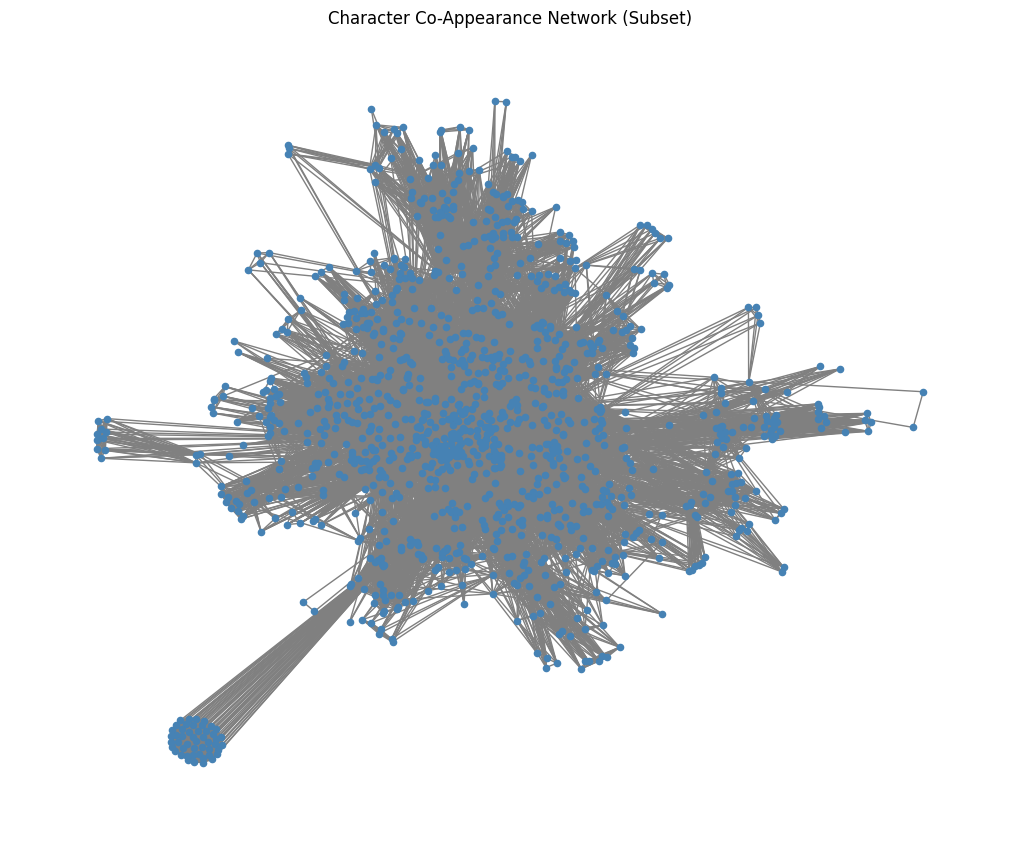

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub, pos, node_size=20, edge_color="gray", node_color="steelblue")
plt.title("Character Co-Appearance Network (Subset)")
plt.show()

While the layout reveals the overall density and structure of the network, it lacks visual cues about the relative importance of nodes or group structures. All nodes are drawn with the same size and color, making it difficult to distinguish key players or communities within the universe.

In [24]:
top_n = 20
top_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_node_ids = [node for node, _ in top_nodes]


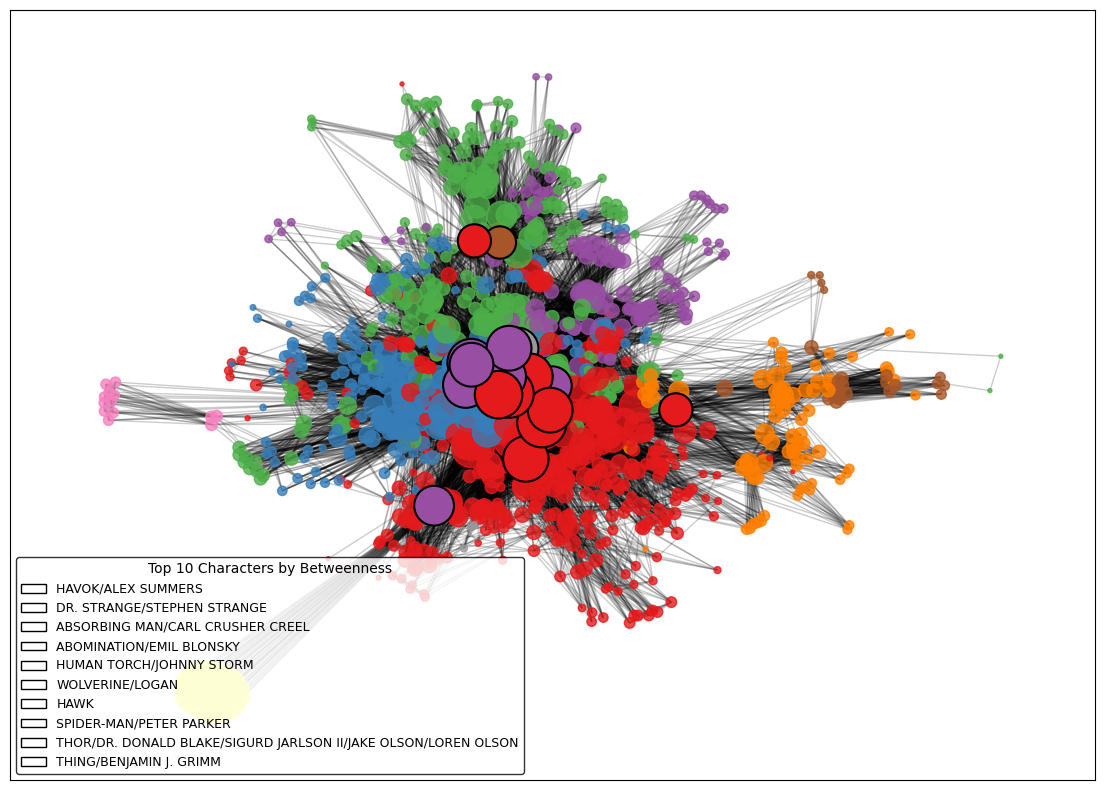

In [33]:
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

# Community detection
communities = list(greedy_modularity_communities(G_sub))
node_community = {node: i for i, comm in enumerate(communities) for node in comm}

# Centrality
node_sizes = [5000 * centrality[n] for n in G_sub.nodes()]
node_colors = [node_community[n] for n in G_sub.nodes()]

# Split nodes into top and non-top for styling
top_nodes_set = set(top_node_ids)
regular_nodes = [n for n in G_sub.nodes() if n not in top_nodes_set]

# Draw the full graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_sub, seed=42)

# Draw non-top nodes
nx.draw_networkx_nodes(G_sub, pos,
    nodelist=regular_nodes,
    node_color=[node_colors[list(G_sub.nodes()).index(n)] for n in regular_nodes],
    node_size=[node_sizes[list(G_sub.nodes()).index(n)] for n in regular_nodes],
    cmap=plt.cm.Set1,
    alpha=0.8
)

# Draw top nodes with black borders
nx.draw_networkx_nodes(G_sub, pos,
    nodelist=top_node_ids,
    node_color=[node_colors[list(G_sub.nodes()).index(n)] for n in top_node_ids],
    node_size=[node_sizes[list(G_sub.nodes()).index(n)] for n in top_node_ids],
    edgecolors='black',
    linewidths=1.5,
    cmap=plt.cm.Set1,
    alpha=1
)

# Draw edges
nx.draw_networkx_edges(G_sub, pos, alpha=0.2)

from matplotlib.patches import Patch

# Create clean label list
legend_labels = [character_names[n] for n in top_node_ids[:10]]

# we can cuild "dummy" handles with just black-edged circles to easily identify labels
legend_handles = [Patch(facecolor='white', edgecolor='black', label=name) for name in legend_labels]

plt.legend(
    handles=legend_handles,
    title="Top 10 Characters by Betweenness",
    loc='lower left',
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    fancybox=True,
    edgecolor='black'
)



This version helps us see:

Key central characters (larger nodes), like Wolverine and Spider-Man

Narrative communities (color clusters), which often reflect team memberships, arcs, or thematic groupings (like, say X-Men, Avengers, cosmic characters)

Peripheral characters that cluster tightly in distinct story bubbles (such as the isolated yellow cluster behind the legend box)

Bridges between clusters, indicating characters who connect otherwise separate storylines

This project represents an initial exploration of a subset of a much larger dataset capturing character co-appearances within the always-expanding Marvel Universe. By analyzing centrality metrics and community structures, we could continue finding narrative patterns and identify key characters who serve as either central figures or critical connectors across storylines.

Further exploration could include how character importance evolves over time. Deeper analysis might even reveal how Marvel's storytelling strategies contribute to the narrative design and world-building of its shared universe